In [1]:
%matplotlib notebook

In [86]:
import cv2
import mediapipe as mp
import urllib.request
import numpy as np
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from IPython.display import Video
import seaborn as sns
sns.set()

mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic
mp_pose = mp.solutions.pose
mp_face_mesh = mp.solutions.face_mesh

# poselandmarks_list = my_nb_helpers.poselandmarks_list

# v1

In [34]:
input_filename = './videos-squats/squats-side-jim.mp4'

In [25]:
output_filename = './videos-squats/output/output_squats-side-jim.avi'

In [26]:
# v1
with mp_pose.Pose(static_image_mode=False,min_detection_confidence=0.5,min_tracking_confidence=0.5,model_complexity=1,smooth_landmarks=True,) as pose:
    # Create VideoCapture object
    cap = cv2.VideoCapture(input_filename)

	# Raise error if file cannot be opened
    if cap.isOpened() == False:
        print("Error opening video stream or file")
        raise TypeError

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    size = (frame_width, frame_height)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    # Get the number of frames in the video
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # create videowriter object to create new video with pose estimation overlayed
    videowriter = cv2.VideoWriter(output_filename,cv2.VideoWriter_fourcc(*'MJPG'),fps,size)
    
    # Create a NumPy array to store the pose data as before
    # The shape is 3x33xlength - 3D XYZ data for 33 landmarks across 'length' frames
    # data = np.empty((3, len(poselandmarks_list), length))    
    # The shape is 2x33xlength - 2D XY data for 33 landmarks across 'length' frames
    data = np.empty((2, 33, length))    
    
	# For each image in the video, extract the spatial pose data and save it in the appropriate spot in the `data` array 
    frame_num = 0
    
    
    while cap.isOpened():
        # read current frame
        ret, frame = cap.read()
        if not ret:
            break

        # recolor frame to RGB and save to new cv2 object'image'
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        image.flags.writeable = False
        
        # make detection
        results = pose.process(image)
        
        # recolor back to BGR
        image.flags.writeable = True
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        # get landmark results for current frame
        landmarks = results.pose_world_landmarks.landmark

        # fill in coordinate data for each landmark for current frame
        for i in range(len(mp_pose.PoseLandmark)):
#             data[:, i, frame_num] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)
            data[:, i, frame_num] = (landmarks[i].x, landmarks[i].y)

        
        frame_num += 1
        
        # render detection
        mp_drawing.draw_landmarks(image, results.pose_landmarks,mp_pose.POSE_CONNECTIONS,
                                  mp_drawing.DrawingSpec(color=(245,117,66),thickness=2, circle_radius=2),
                                  mp_drawing.DrawingSpec(color=(245,66,230),thickness=2, circle_radius=2)
                                 )
        # write pose estimation overlay video data
        videowriter.write(image)
        # display image (not sure we need to do this)
        cv2.imshow("Mediapipe Frame", image)
    
    cap.release()
    videowriter.release()
    cv2.destroyAllWindows()
    print("The video was successfully saved")

The video was successfully saved


In [108]:
ls video_data/

download-youtube.py        plank-badform-badback.mp4
output/                    plank-goodform.mp4


# v2

### some useful functions
should put these into a separate utils.py module


In [2]:
# some useful functions
def find_angle(p1, p2, ref_pt = np.array([0,0])):
    p1_ref = p1 - ref_pt
    p2_ref = p2 - ref_pt

    cos_theta = (np.dot(p1_ref,p2_ref)) / (1.0 * np.linalg.norm(p1_ref) * np.linalg.norm(p2_ref))
    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
    # note degree will always be less than 180 -- pretty sure...      
    degree = int(180 / np.pi) * theta

    return int(degree)

def get_landmark_array(pose_landmark, key, frame_width, frame_height):

    denorm_x = int(pose_landmark[key].x * frame_width)
    denorm_y = int(pose_landmark[key].y * frame_height)

    return np.array([denorm_x, denorm_y])

def get_landmark_features(kp_results, dict_features, feature, frame_width, frame_height):

    if feature == 'nose':
        return get_landmark_array(kp_results, dict_features[feature], frame_width, frame_height)

    elif feature == 'left' or 'right':
        shldr_coord = get_landmark_array(kp_results, dict_features[feature]['shoulder'], frame_width, frame_height)
        elbow_coord   = get_landmark_array(kp_results, dict_features[feature]['elbow'], frame_width, frame_height)
        wrist_coord   = get_landmark_array(kp_results, dict_features[feature]['wrist'], frame_width, frame_height)
        hip_coord   = get_landmark_array(kp_results, dict_features[feature]['hip'], frame_width, frame_height)
        knee_coord   = get_landmark_array(kp_results, dict_features[feature]['knee'], frame_width, frame_height)
        ankle_coord   = get_landmark_array(kp_results, dict_features[feature]['ankle'], frame_width, frame_height)
        foot_coord   = get_landmark_array(kp_results, dict_features[feature]['foot'], frame_width, frame_height)

        return shldr_coord, elbow_coord, wrist_coord, hip_coord, knee_coord, ankle_coord, foot_coord
    
    else:
       raise ValueError("feature needs to be either 'nose', 'left' or 'right")
    
def draw_dotted_line(frame, lm_coord, start, end, line_color):
    pix_step = 0

    for i in range(start, end+1, 8):
        cv2.circle(frame, (lm_coord[0], i+pix_step), 2, line_color, -1, lineType=cv2.LINE_AA)

    return frame


### global vars

In [3]:
left_features = {
    'shoulder': mp_pose.PoseLandmark.LEFT_SHOULDER.value, # 11
    'elbow'   : mp_pose.PoseLandmark.LEFT_ELBOW.value,    # 13
    'wrist'   : mp_pose.PoseLandmark.LEFT_WRIST.value,    # 15                    
    'hip'     : mp_pose.PoseLandmark.LEFT_HIP.value,      # 23
    'knee'    : mp_pose.PoseLandmark.LEFT_KNEE.value,     # 25
    'ankle'   : mp_pose.PoseLandmark.LEFT_ANKLE.value,    # 27
    'foot'    : mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value      # 31
}

right_features = {
    'shoulder': 12,
    'elbow'   : 14,
    'wrist'   : 16,
    'hip'     : 24,
    'knee'    : 26,
    'ankle'   : 28,
    'foot'    : 32
}
dict_features = {}
dict_features['left'] = left_features
dict_features['right'] = right_features
dict_features['nose'] = 0


# font type
font = cv2.FONT_HERSHEY_SIMPLEX

# line type
linetype = cv2.LINE_AA

# set radius to draw arc
radius = 20

# Colors in BGR format -- but need to be converted to rgb
COLORS = {
    'blue'       : (255, 127, 0), # corrected for RGB
    'red'        : (255, 50, 50),
    'green'      : (0, 255, 127),
    'light_green': (100, 233, 127),
    'yellow'     : (0, 255, 255), # corrected for RGB
    'magenta'    : (255, 0, 255),
    'white'      : (255,255,255),
    'cyan'       : (0, 255, 255),
    'light_blue' : (255, 204, 102) # corrected for RGB
}

### main code for processing frame

In [206]:
def process(frame,pose,videowriter):
    frame_height, frame_width, _ = frame.shape

    # Process the image.
    # recolor frame to RGB
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame.flags.writeable = False
    
    keypoints = pose.process(frame)

    # recolor back to BGR
    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    crit_angles_list = [0,0,0,0]
    
    if keypoints.pose_landmarks:
        ps_lm = keypoints.pose_landmarks

        nose_coord = get_landmark_features(ps_lm.landmark, dict_features, 'nose', frame_width, frame_height)
        left_shldr_coord, left_elbow_coord, left_wrist_coord, left_hip_coord, left_knee_coord, left_ankle_coord, left_foot_coord = \
                            get_landmark_features(ps_lm.landmark, dict_features, 'left', frame_width, frame_height)
        
        
        right_shldr_coord, right_elbow_coord, right_wrist_coord, right_hip_coord, right_knee_coord, right_ankle_coord, right_foot_coord = \
                            get_landmark_features(ps_lm.landmark, dict_features, 'right', frame_width, frame_height)

        offset_angle = find_angle(left_shldr_coord, right_shldr_coord, nose_coord)   
        
        camera_view = 'right'
        #
        # ASSUME camera angle is from the right for now
        #   
        
        # determine camera view (left or right) - front will default to right for now (TODO: handle this better)
        if offset_angle > 35.0:
            # hard-coded for now - determined from squat code author, seems good
            camera_view = 'front'
            print("camera view from front")

        # compute distance for both sides shoulder to foot    
        # from squat code author as well (though need to use x coords rather than y coords for squats)
        dist_l_sh_hip = abs(left_foot_coord[0] - left_shldr_coord[0])
        dist_r_sh_hip = abs(right_foot_coord[0] - right_shldr_coord)[0]        
        if dist_l_sh_hip > dist_r_sh_hip:
            camera_view = 'left'
            print("camera view from left")
            
        
        # assign side specific coords
        if camera_view == 'left':
            shldr_coord = left_shldr_coord
            elbow_coord = left_elbow_coord
            wrist_coord = left_wrist_coord
            hip_coord = left_hip_coord
            knee_coord = left_knee_coord
            ankle_coord = left_ankle_coord
            foot_coord = left_foot_coord

            multiplier = -1
        
        elif camera_view == 'right':
            shldr_coord = right_shldr_coord
            elbow_coord = right_elbow_coord
            wrist_coord = right_wrist_coord
            hip_coord = right_hip_coord
            knee_coord = right_knee_coord
            ankle_coord = right_ankle_coord
            foot_coord = right_foot_coord

            multiplier = 1
        else:
            # just default to right
            shldr_coord = right_shldr_coord
            elbow_coord = right_elbow_coord
            wrist_coord = right_wrist_coord
            hip_coord = right_hip_coord
            knee_coord = right_knee_coord
            ankle_coord = right_ankle_coord
            foot_coord = right_foot_coord

            multiplier = 1

        
        # ------------------- Vertical Angle calculation --------------

#         elbow_vertical_angle = find_angle(wrist_coord, np.array([elbow_coord[0], 0]), elbow_coord)
#         cv2.ellipse(frame, elbow_coord, (30, 30), 
#                     angle = 0, startAngle = -90, endAngle = -90+multiplier*elbow_vertical_angle, 
#                     color = COLORS['white'], thickness = 3, lineType = linetype)

#         draw_dotted_line(frame, elbow_coord, start=elbow_coord[1]-80, end=elbow_coord[1]+20, line_color=COLORS['blue'])
#         cv2.putText(frame, str(elbow_vertical_angle),elbow_coord+15, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

        
#         shoulder_vertical_angle = find_angle(elbow_coord, np.array([shldr_coord[0], 0]), shldr_coord)
#         cv2.ellipse(frame, shldr_coord, (30, 30), 
#                     angle = 0, startAngle = -90, endAngle = -90-multiplier*shoulder_vertical_angle, 
#                     color = COLORS['white'], thickness = 3, lineType = linetype)

#         draw_dotted_line(frame, shldr_coord, start=shldr_coord[1]-80, end=shldr_coord[1]+20, line_color=COLORS['blue'])
#         cv2.putText(frame, str(shoulder_vertical_angle),shldr_coord+15, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

   
        shoulder_vertical_angle = find_angle(hip_coord, np.array([shldr_coord[0], 0]), shldr_coord)
        cv2.ellipse(frame, shldr_coord, (30, 30), 
                    angle = 0, startAngle = -90, endAngle = -90-multiplier*shoulder_vertical_angle, 
                    color = COLORS['white'], thickness = 3, lineType = linetype)

        draw_dotted_line(frame, shldr_coord, start=shldr_coord[1]-80, end=shldr_coord[1]+20, line_color=COLORS['blue'])
        cv2.putText(frame, str(shoulder_vertical_angle),shldr_coord+[-40,-40], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)


#         shoulder_vertical_angle2 = find_angle(elbow_coord, np.array([shldr_coord[0], 0]), shldr_coord)
#         cv2.ellipse(frame, shldr_coord, (30, 30), 
#                     angle = 0, startAngle = -90, endAngle = -90-multiplier*(shoulder_vertical_angle2), 
#                     color = COLORS['white'], thickness = 3, lineType = linetype)
#         shoulder_vertical_angle2 -= shoulder_vertical_angle
# #         draw_dotted_line(frame, shldr_coord, start=shldr_coord[1]-80, end=shldr_coord[1]+20, line_color=COLORS['blue'])
#         cv2.putText(frame, str(shoulder_vertical_angle2),shldr_coord+[-60,40], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)


#         shoulder_vertical_angle2 = find_angle(nose_coord, np.array([shldr_coord[0], 0]), shldr_coord)
#         cv2.ellipse(frame, shldr_coord, (30, 30), 
#                     angle = 0, startAngle = -90, endAngle = -90+multiplier*shoulder_vertical_angle2, 
#                     color = COLORS['white'], thickness = 3, lineType = linetype)

# #         draw_dotted_line(frame, shldr_coord, start=shldr_coord[1]-80, end=shldr_coord[1]+20, line_color=COLORS['blue'])
#         cv2.putText(frame, str(shoulder_vertical_angle2),nose_coord+[-40,-40], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)



    
        hip_vertical_angle = find_angle(knee_coord, np.array([hip_coord[0], 0]), hip_coord)
        cv2.ellipse(frame, hip_coord, (30, 30), 
                    angle = 0, startAngle = -90, endAngle = -90-multiplier*hip_vertical_angle, 
                    color = COLORS['white'], thickness = 3, lineType = linetype)

        draw_dotted_line(frame, hip_coord, start=hip_coord[1]-80, end=hip_coord[1]+20, line_color=COLORS['blue'])
        cv2.putText(frame, str(hip_vertical_angle),hip_coord+[-40,-40], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)


        knee_vertical_angle = find_angle(ankle_coord, np.array([knee_coord[0], 0]), knee_coord)
        cv2.ellipse(frame, knee_coord, (30, 30), 
                    angle = 0, startAngle = -90, endAngle = -90-multiplier*knee_vertical_angle, 
                    color = COLORS['white'], thickness = 3,  lineType = linetype)

        draw_dotted_line(frame, knee_coord, start=knee_coord[1]-50, end=knee_coord[1]+20, line_color=COLORS['blue'])
        cv2.putText(frame, str(knee_vertical_angle),knee_coord+[-40,-40], cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)


        ankle_vertical_angle = find_angle(knee_coord, np.array([ankle_coord[0], 0]), ankle_coord)
        cv2.ellipse(frame, ankle_coord, (30, 30),
                    angle = 0, startAngle = -90, endAngle = -90+multiplier*ankle_vertical_angle,
                    color = COLORS['white'], thickness = 3,  lineType=linetype)

        draw_dotted_line(frame, ankle_coord, start=ankle_coord[1]-50, end=ankle_coord[1]+20, line_color=COLORS['blue'])
        cv2.putText(frame, str(ankle_vertical_angle),ankle_coord+15, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

        
        # ------------------------------------------------------------


        # Join landmarks.
#         cv2.line(frame, shldr_coord, nose_coord, COLORS['light_blue'], 4, lineType=linetype)
        cv2.line(frame, shldr_coord, elbow_coord, COLORS['light_blue'], 4, lineType=linetype)
        cv2.line(frame, wrist_coord, elbow_coord, COLORS['light_blue'], 4, lineType=linetype)
        cv2.line(frame, shldr_coord, hip_coord, COLORS['light_blue'], 4, lineType=linetype)
        cv2.line(frame, knee_coord, hip_coord, COLORS['light_blue'], 4,  lineType=linetype)
        cv2.line(frame, ankle_coord, knee_coord, COLORS['light_blue'], 4,  lineType=linetype)
        cv2.line(frame, ankle_coord, foot_coord, COLORS['light_blue'], 4,  lineType=linetype)

        # Plot landmark points
#         cv2.circle(frame, nose_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, shldr_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, elbow_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, wrist_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, hip_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, knee_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, ankle_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, foot_coord, 7, COLORS['yellow'], -1,  lineType=linetype)

        
        # write information to video frame
        videowriter.write(frame)
    
        
        # save frame angles for later analyses
        crit_angles_list = [shoulder_vertical_angle, hip_vertical_angle, knee_vertical_angle, ankle_vertical_angle]
        
    
    return keypoints, crit_angles_list

# example processing of an .mp4 file

In [211]:
input_filename = './video_data/joshplank-highhips.mp4'
output_filename = './video_data/output/outputv2_joshplank-highhips.avi'
# input_filename = './video_data/plank-badform-badback.mp4'
# output_filename = './video_data/output/outputv2_plank-badform-badback.avi'
# # from left side
# input_filename = './video_data/plank-side-2.mp4'
# output_filename = './video_data/output/outputv2_plank-side-2.avi'

In [212]:
# version 2 
with mp_pose.Pose(static_image_mode=False,min_detection_confidence=0.5,min_tracking_confidence=0.5,model_complexity=1,smooth_landmarks=True) as pose:
    # Create VideoCapture object
    cap = cv2.VideoCapture(input_filename)

	# Raise error if file cannot be opened
    if cap.isOpened() == False:
        print("Error opening video stream or file")
        raise TypeError

    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    size = (frame_width, frame_height)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    # Get the number of frames in the video
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # create videowriter object to create new video with pose estimation overlayed
    videowriter = cv2.VideoWriter(output_filename,cv2.VideoWriter_fourcc(*'MJPG'),fps,size)
    
    # Create a NumPy array to store the pose data as before
    # The shape is 3x33xlength - 3D XYZ data for 33 landmarks across 'length' frames
    # data = np.empty((3, len(poselandmarks_list), length))    
    # The shape is 2x33xlength - 2D XY data for 33 landmarks across 'length' frames
    data = np.empty((2, 33, length))    
    angles_data = np.empty((length, 4)) 
	# For each image in the video, extract the spatial pose data and save it in the appropriate spot in the `data` array 
    frame_num = 0
    
    while cap.isOpened():
        # read current frame
        ret, frame = cap.read()
        if not ret:
            break

        results, angles_list = process(frame,pose,videowriter)
        
        landmarks = results.pose_world_landmarks.landmark
        # landmarks = results.pose_landmarks.landmark
        for i in range(len(mp_pose.PoseLandmark)):
            data[:, i, frame_num] = (landmarks[i].x, landmarks[i].y)
        
        for i in range(len(angles_list)):
            angles_data[frame_num,i] = angles_list[i]
            
        frame_num += 1
        

    cap.release()
    videowriter.release()
    cv2.destroyAllWindows()
    print("The video was successfully saved")

camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera vie

camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera view from left
camera vie

In [194]:
angles_data[:,0:5]

array([[94., 94., 96., 82.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [93., 94., 95., 83.],
       [93., 94., 96., 83.],
       [93., 94., 96., 83.],
       [93., 94., 96., 83.],
       [93., 94., 96., 83.],
       [93., 94., 96., 83.],
       [93., 94., 96., 83.],
       [93., 94., 96., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 94., 95., 83.],
       [94., 9

In [213]:
col_names = ['shoulder', 'hip', 'knee', 'ankle']
df = pd.DataFrame(data=angles_data,columns=col_names)

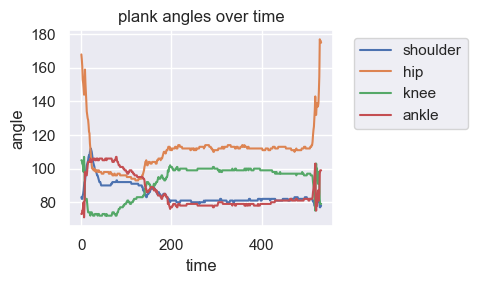

In [214]:
df.plot(figsize=(5,3))
plt.title('plank angles over time')
plt.xlabel('time')
plt.ylabel('angle')
plt.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
plt.tight_layout()

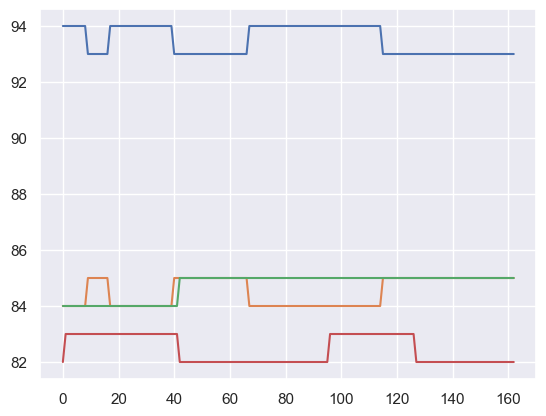

In [151]:
for i in range(4):
    plt.plot(angles_data[:,i])

In [152]:
from IPython import display

display.Video(output_filename)

## example processing an image file

In [ ]:
input_filename = './images/Proper-Plank-Form.png'
output_filename = './images/Proper-Plank-Form_output.jpg'

In [ ]:
with mp_pose.Pose(static_image_mode=True, model_complexity=2,enable_segmentation=True,min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:
	# Read the file in and get dims
	image = cv2.imread(input_filename)
	dims = image.shape

	# Convert the BGR image to RGB and then process with the `Pose` object.
	results = pose.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
	# Extract landmarks
	try:
		landmarks = results.pose_landmarks.landmark
    except:
		pass


	# segment person out of image
	red_img = np.zeros_like(image,dtype=np.uint8)
	red_img[:,:] = (255,255,255)
	segm_2class = 0.2 + 0.8*results.segmentation_mask
	segm_2class = np.repeat(segm_2class[...,np.newaxis],3,axis=2)
	image = image * segm_2class + red_img * (1 - segm_2class)

	# Render detections
	mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_pose.POSE_CONNECTIONS,mp_drawing.DrawingSpec(color=(245,117,66), thickness=10, circle_radius=4),mp_drawing.DrawingSpec(color=(245,66,230), thickness=10, circle_radius=4))

	# # Save image with drawing
	cv2.imwrite(output_filename, image)


In [59]:
def oldprocess(frame,pose,videowriter):
    frame_height, frame_width, _ = frame.shape

    # Process the image.
    # recolor frame to RGB and save to new cv2 object'image'
    frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frame.flags.writeable = False
    
    keypoints = pose.process(frame)

    # recolor back to BGR
    frame.flags.writeable = True
    frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    
    if keypoints.pose_landmarks:
        ps_lm = keypoints.pose_landmarks

        nose_coord = get_landmark_features(ps_lm.landmark, dict_features, 'nose', frame_width, frame_height)
        left_shldr_coord, left_elbow_coord, left_wrist_coord, left_hip_coord, left_knee_coord, left_ankle_coord, left_foot_coord = \
                            get_landmark_features(ps_lm.landmark, dict_features, 'left', frame_width, frame_height)
        
        
        right_shldr_coord, right_elbow_coord, right_wrist_coord, right_hip_coord, right_knee_coord, right_ankle_coord, right_foot_coord = \
                            get_landmark_features(ps_lm.landmark, dict_features, 'right', frame_width, frame_height)

        offset_angle = find_angle(left_shldr_coord, right_shldr_coord, nose_coord)   
        
        camera_view = 'right'
        #
        # ASSUME camera angle is from the right for now
        #
        
        if camera_view == 'left':
            shldr_coord = left_shldr_coord
            elbow_coord = left_elbow_coord
            wrist_coord = left_wrist_coord
            hip_coord = left_hip_coord
            knee_coord = left_knee_coord
            ankle_coord = left_ankle_coord
            foot_coord = left_foot_coord

            multiplier = -1
        
        elif camera_view == 'right':
            shldr_coord = right_shldr_coord
            elbow_coord = right_elbow_coord
            wrist_coord = right_wrist_coord
            hip_coord = right_hip_coord
            knee_coord = right_knee_coord
            ankle_coord = right_ankle_coord
            foot_coord = right_foot_coord

            multiplier = 1
        else:
            # just default to right
            shldr_coord = right_shldr_coord
            elbow_coord = right_elbow_coord
            wrist_coord = right_wrist_coord
            hip_coord = right_hip_coord
            knee_coord = right_knee_coord
            ankle_coord = right_ankle_coord
            foot_coord = right_foot_coord

            multiplier = 1

        
        # ------------------- Vertical Angle calculation --------------

        shoulder_vertical_angle = find_angle(elbow_coord, np.array([shldr_coord[0], 0]), shldr_coord)
        cv2.ellipse(frame, shldr_coord, (30, 30), 
                    angle = 0, startAngle = -90, endAngle = -90+multiplier*shoulder_vertical_angle, 
                    color = COLORS['white'], thickness = 3, lineType = linetype)

        draw_dotted_line(frame, shldr_coord, start=shldr_coord[1]-80, end=shldr_coord[1]+20, line_color=COLORS['blue'])
        cv2.putText(frame, str(shoulder_vertical_angle),shldr_coord+15, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

        
        hip_vertical_angle = find_angle(shldr_coord, np.array([hip_coord[0], 0]), hip_coord)
        cv2.ellipse(frame, hip_coord, (30, 30), 
                    angle = 0, startAngle = -90, endAngle = -90+multiplier*hip_vertical_angle, 
                    color = COLORS['white'], thickness = 3, lineType = linetype)

        draw_dotted_line(frame, hip_coord, start=hip_coord[1]-80, end=hip_coord[1]+20, line_color=COLORS['blue'])
        cv2.putText(frame, str(hip_vertical_angle),hip_coord+15, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)


        knee_vertical_angle = find_angle(hip_coord, np.array([knee_coord[0], 0]), knee_coord)
        cv2.ellipse(frame, knee_coord, (30, 30), 
                    angle = 0, startAngle = -90, endAngle = -90+multiplier*knee_vertical_angle, 
                    color = COLORS['white'], thickness = 3,  lineType = linetype)

        draw_dotted_line(frame, knee_coord, start=knee_coord[1]-50, end=knee_coord[1]+20, line_color=COLORS['blue'])
        cv2.putText(frame, str(knee_vertical_angle),knee_coord+15, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)



        ankle_vertical_angle = find_angle(knee_coord, np.array([ankle_coord[0], 0]), ankle_coord)
        cv2.ellipse(frame, ankle_coord, (30, 30),
                    angle = 0, startAngle = -90, endAngle = -90+multiplier*ankle_vertical_angle,
                    color = COLORS['white'], thickness = 3,  lineType=linetype)

        draw_dotted_line(frame, ankle_coord, start=ankle_coord[1]-50, end=ankle_coord[1]+20, line_color=COLORS['blue'])
        cv2.putText(frame, str(ankle_vertical_angle),ankle_coord+15, cv2.FONT_HERSHEY_SIMPLEX, 0.7, (255, 255, 255), 2, cv2.LINE_AA)

        
        # ------------------------------------------------------------


        # Join landmarks.
        cv2.line(frame, shldr_coord, elbow_coord, COLORS['light_blue'], 4, lineType=linetype)
        cv2.line(frame, wrist_coord, elbow_coord, COLORS['light_blue'], 4, lineType=linetype)
        cv2.line(frame, shldr_coord, hip_coord, COLORS['light_blue'], 4, lineType=linetype)
        cv2.line(frame, knee_coord, hip_coord, COLORS['light_blue'], 4,  lineType=linetype)
        cv2.line(frame, ankle_coord, knee_coord, COLORS['light_blue'], 4,  lineType=linetype)
        cv2.line(frame, ankle_coord, foot_coord, COLORS['light_blue'], 4,  lineType=linetype)

        # Plot landmark points
        cv2.circle(frame, shldr_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, elbow_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, wrist_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, hip_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, knee_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, ankle_coord, 7, COLORS['yellow'], -1,  lineType=linetype)
        cv2.circle(frame, foot_coord, 7, COLORS['yellow'], -1,  lineType=linetype)

        
        # write information to video frame
        videowriter.write(frame)
    
    return keypoints

In [39]:
def find_angle(p1, p2, ref_pt = np.array([0,0])):
    p1_ref = p1 - ref_pt
    p2_ref = p2 - ref_pt

    cos_theta = (np.dot(p1_ref,p2_ref)) / (1.0 * np.linalg.norm(p1_ref) * np.linalg.norm(p2_ref))
    theta = np.arccos(np.clip(cos_theta, -1.0, 1.0))
            
    degree = int(180 / np.pi) * theta

    return int(degree)

def get_landmark_array(pose_landmark, key, frame_width, frame_height):

    denorm_x = int(pose_landmark[key].x * frame_width)
    denorm_y = int(pose_landmark[key].y * frame_height)

    return np.array([denorm_x, denorm_y])

def get_landmark_features(kp_results, dict_features, feature, frame_width, frame_height):

    if feature == 'nose':
        return get_landmark_array(kp_results, dict_features[feature], frame_width, frame_height)

    elif feature == 'left' or 'right':
        shldr_coord = get_landmark_array(kp_results, dict_features[feature]['shoulder'], frame_width, frame_height)
        elbow_coord   = get_landmark_array(kp_results, dict_features[feature]['elbow'], frame_width, frame_height)
        wrist_coord   = get_landmark_array(kp_results, dict_features[feature]['wrist'], frame_width, frame_height)
        hip_coord   = get_landmark_array(kp_results, dict_features[feature]['hip'], frame_width, frame_height)
        knee_coord   = get_landmark_array(kp_results, dict_features[feature]['knee'], frame_width, frame_height)
        ankle_coord   = get_landmark_array(kp_results, dict_features[feature]['ankle'], frame_width, frame_height)
        foot_coord   = get_landmark_array(kp_results, dict_features[feature]['foot'], frame_width, frame_height)

        return shldr_coord, elbow_coord, wrist_coord, hip_coord, knee_coord, ankle_coord, foot_coord
    
    else:
       raise ValueError("feature needs to be either 'nose', 'left' or 'right")
    
def draw_dotted_line(frame, lm_coord, start, end, line_color):
    pix_step = 0

    for i in range(start, end+1, 8):
        cv2.circle(frame, (lm_coord[0], i+pix_step), 2, line_color, -1, lineType=cv2.LINE_AA)

    return frame


In [89]:
whos

Variable                Type                          Data/Info
---------------------------------------------------------------
COLORS                  dict                          n=9
Image                   module                        <module 'PIL.Image' from <...>e-packages/PIL/Image.py'>
Video                   type                          <class 'IPython.core.display.Video'>
animation               module                        <module 'matplotlib.anima<...>matplotlib/animation.py'>
calculate_angle         function                      <function calculate_angle at 0x11d03e940>
cap                     VideoCapture                  < cv2.VideoCapture 0x12ccc86b0>
check_knees_toes        function                      <function check_knees_toes at 0x12bd15e50>
curframe                int                           445
cv2                     module                        <module 'cv2' from '/User<...>ackages/cv2/__init__.py'>
data                    ndarray                       2x

In [7]:
# interesting landmarks
list(mp_pose.PoseLandmark)

[<PoseLandmark.NOSE: 0>,
 <PoseLandmark.LEFT_EYE_INNER: 1>,
 <PoseLandmark.LEFT_EYE: 2>,
 <PoseLandmark.LEFT_EYE_OUTER: 3>,
 <PoseLandmark.RIGHT_EYE_INNER: 4>,
 <PoseLandmark.RIGHT_EYE: 5>,
 <PoseLandmark.RIGHT_EYE_OUTER: 6>,
 <PoseLandmark.LEFT_EAR: 7>,
 <PoseLandmark.RIGHT_EAR: 8>,
 <PoseLandmark.MOUTH_LEFT: 9>,
 <PoseLandmark.MOUTH_RIGHT: 10>,
 <PoseLandmark.LEFT_SHOULDER: 11>,
 <PoseLandmark.RIGHT_SHOULDER: 12>,
 <PoseLandmark.LEFT_ELBOW: 13>,
 <PoseLandmark.RIGHT_ELBOW: 14>,
 <PoseLandmark.LEFT_WRIST: 15>,
 <PoseLandmark.RIGHT_WRIST: 16>,
 <PoseLandmark.LEFT_PINKY: 17>,
 <PoseLandmark.RIGHT_PINKY: 18>,
 <PoseLandmark.LEFT_INDEX: 19>,
 <PoseLandmark.RIGHT_INDEX: 20>,
 <PoseLandmark.LEFT_THUMB: 21>,
 <PoseLandmark.RIGHT_THUMB: 22>,
 <PoseLandmark.LEFT_HIP: 23>,
 <PoseLandmark.RIGHT_HIP: 24>,
 <PoseLandmark.LEFT_KNEE: 25>,
 <PoseLandmark.RIGHT_KNEE: 26>,
 <PoseLandmark.LEFT_ANKLE: 27>,
 <PoseLandmark.RIGHT_ANKLE: 28>,
 <PoseLandmark.LEFT_HEEL: 29>,
 <PoseLandmark.RIGHT_HEEL: 30>,
 <P

In [8]:
def calculate_angle(a,b,c):
    a = np.array(a) # First
    b = np.array(b) # Mid
    c = np.array(c) # End
    
    radians = np.arctan2(c[1]-b[1], c[0]-b[0]) - np.arctan2(a[1]-b[1], a[0]-b[0])
    angle = np.abs(radians*180.0/np.pi)
    
    if angle >180.0:
        angle = 360-angle
        
    return angle 

In [ ]:
# can go through the data now and compute angles for a few landmarks of interest
# WILL NEED TO ASSUME CAMERA FRONT OR SIDE (START WITH FROM LEFT SIDE VIEW)


In [27]:
# currently computing hip angle between shoulder and knee 

# -- should compute against shoulder and vertical line from hip

left_hip_angles = []
for curframe in range(length):
    left_hip_angles.append(calculate_angle(data[:,mp_pose.PoseLandmark.LEFT_SHOULDER.value,curframe],data[:,mp_pose.PoseLandmark.LEFT_HIP.value,curframe],data[:,mp_pose.PoseLandmark.LEFT_KNEE.value,curframe])) 
    
        

In [28]:
left_hip_angles

[121.28654286313059,
 121.72043513918206,
 122.92597271516166,
 124.10854520779125,
 124.92362447008767,
 126.10983674874893,
 127.42339777153211,
 129.19999574248249,
 130.2079349334027,
 131.67031833421612,
 133.13142983943382,
 134.8050684590668,
 136.2239894135449,
 138.63062111435642,
 140.6955481890813,
 142.21615265081638,
 145.0802034617815,
 146.70244074571673,
 149.41713446801774,
 149.96258964487288,
 154.31856470960247,
 155.05741261624422,
 156.30286709560573,
 157.29502684442403,
 157.18040363149555,
 156.9504383900191,
 157.25157318550353,
 157.14513713351477,
 157.4177660655081,
 158.01993998787555,
 158.05996058450975,
 157.97869231715188,
 157.9313529207948,
 157.70666174377237,
 157.19644154568064,
 156.60289300638243,
 155.16455487935127,
 153.8890104107761,
 152.77334531945593,
 151.3028161378603,
 150.18089331392017,
 147.56218069636893,
 146.1467784689146,
 142.73625339046708,
 140.99386137769324,
 140.39677348034257,
 139.44574778509508,
 137.87121142396452,
 13

In [29]:
min(left_hip_angles)

79.0836760990698

In [30]:
max(left_hip_angles)

166.60655896960105

In [55]:
# check if knees go past toes
# something doesn't check out on this -- the video does not support this
def check_knees_toes(data):
    for curframe in range(data.shape[-1]):
        left_knee_x = data[0,mp_pose.PoseLandmark.LEFT_KNEE.value,curframe]
        left_toes_x = data[0,mp_pose.PoseLandmark.LEFT_FOOT_INDEX.value,curframe]
        print(str(left_knee_x)+","+str(left_toes_x))
#         print(curframe)
        if left_knee_x < left_toes_x:
            print("Knees over toes on frame: "+str(curframe))
            
    return 

In [56]:
check_knees_toes(data)

-0.15691983699798584,-0.15097427368164062
Knees over toes on frame: 0
-0.15692467987537384,-0.15267464518547058
Knees over toes on frame: 1
-0.15583547949790955,-0.15378735959529877
Knees over toes on frame: 2
-0.1555018126964569,-0.15433061122894287
Knees over toes on frame: 3
-0.15539568662643433,-0.15346293151378632
Knees over toes on frame: 4
-0.15241490304470062,-0.1481679528951645
Knees over toes on frame: 5
-0.1467239260673523,-0.14321695268154144
Knees over toes on frame: 6
-0.14137373864650726,-0.13917705416679382
Knees over toes on frame: 7
-0.1379622370004654,-0.13771790266036987
Knees over toes on frame: 8
-0.13303521275520325,-0.13432542979717255
-0.1284915953874588,-0.1264357715845108
Knees over toes on frame: 10
-0.12428326159715652,-0.12327991425991058
Knees over toes on frame: 11
-0.11845994740724564,-0.12393688410520554
-0.11040650308132172,-0.11609877645969391
-0.10487572103738785,-0.1034189909696579
Knees over toes on frame: 14
-0.09953968226909637,-0.09932298213243

In [42]:
data.shape[-1]

446

In [12]:
with mp_pose.Pose(min_detection_confidence=0.5, min_tracking_confidence=0.5) as pose:

	# Create VideoCapture object
    cap = cv2.VideoCapture(file)

	# Raise error if file cannot be opened
    if cap.isOpened() == False:
        print("Error opening video stream or file")
        raise TypeError

	# Get the number of frames in the video
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    # Create a NumPy array to store the pose data as before
    # The shape is 3x33x144 - 3D XYZ data for 33 landmarks across 144 frames
    # data = np.empty((3, len(poselandmarks_list), length))    
    data = np.empty((3, 33, length))    
    
	# For each image in the video, extract the spatial pose data and save it in the appropriate spot in the `data` array 
    frame_num = 0
    while cap.isOpened():
        ret, image = cap.read()
        if not ret:
            break

        image = cv2.cvtColor(cv2.flip(image, 1), cv2.COLOR_BGR2RGB)
        results = pose.process(image)
        
        landmarks = results.pose_world_landmarks.landmark
        # landmarks = results.pose_landmarks.landmark
        for i in range(len(mp_pose.PoseLandmark)):
            data[:, i, frame_num] = (landmarks[i].x, landmarks[i].y, landmarks[i].z)  
        
        frame_num += 1
    
    # Close the video file
    cap.release()


In [13]:
data.shape[-1]

446

In [16]:
# fig = plt.figure()
# fig.set_size_inches(7, 7, True)
# ax = fig.add_subplot(projection='3d')

# anim = my_nb_helpers.time_animate(data, fig, ax)

In [5]:
plt.show()

In [6]:
anim